In [1]:
import pandas as pd
import numpy as np

# Load the dataset
file_path = './dataset/SMOTE_data.csv'
df = pd.read_csv(file_path)

In [2]:
df.shape

(2903068, 10)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2903068 entries, 0 to 2903067
Data columns (total 10 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   dst2src_first_seen_ms      float64
 1   dst2src_last_seen_ms       float64
 2   dst2src_max_piat_ms        float64
 3   bidirectional_syn_packets  float64
 4   src2dst_syn_packets        float64
 5   application_name           float64
 6   application_category_name  float64
 7   application_is_guessed     float64
 8   application_confidence     float64
 9   label_mul                  float64
dtypes: float64(10)
memory usage: 221.5 MB


In [4]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Sample DataFrame creation (replace this with your actual DataFrame)
data = {
    'dst2src_first_seen_ms': np.random.rand(100),
    'dst2src_last_seen_ms': np.random.rand(100),
    'dst2src_max_piat_ms': np.random.rand(100),
    'bidirectional_syn_packets': np.random.rand(100),
    'src2dst_syn_packets': np.random.rand(100),
    'application_is_guessed': np.random.randint(0, 2, 100),
    'application_confidence': np.random.rand(100),
    'label_mul': np.random.randint(0, 15, 100)
}

df = pd.DataFrame(data)

# Create binary labels
df['binary_label'] = df['label_mul'].apply(lambda x: 0 if x == 0 else 1)

# Prepare features and labels
features = df.drop(columns=['label_mul', 'binary_label', 'application_is_guessed', 'application_confidence'])
labels = df['binary_label'].values





In [5]:
labels

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1])

In [6]:
pip install imblearn


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [7]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt

2025-05-20 10:32:19.224787: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-20 10:32:19.235843: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747737139.247218      63 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747737139.250252      63 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-20 10:32:19.264520: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [8]:
def load_and_preprocess_data(filepath):
    # Load the data
    df = pd.read_csv(filepath)
    
    # Create binary labels from 'label_mul'
    df['binary_label'] = df['label_mul'].apply(lambda x: 0 if x == 0 else 1)
    
    # Prepare features and labels
    y = df['binary_label'].values  # Use the binary labels
    X = df.drop(['label_mul', 'binary_label'], axis=1).values  # Drop the original label and binary label
    
    # Scale the features
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Reshape the data for LSTM (timesteps, features)
    timesteps, features = 1, X_scaled.shape[1] // 1
    X_reshaped = X_scaled.reshape(-1, timesteps, features)
    
    return X_reshaped, y, timesteps, features


In [ ]:
def load_and_preprocess_data(filepath):
    df = pd.read_csv(filepath)
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(df['label_mul'])
    y = to_categorical(y_encoded)
    X = df.drop(['label_mul'], axis=1).values
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)
    timesteps, features = 1, X_scaled.shape[1] // 1
    X_reshaped = X_scaled.reshape(-1, timesteps, features)
    return X_reshaped, y, timesteps, features


In [9]:
def distribute_data_dirichlet(X, y, num_clients, alpha=0.01):
    y_labels = np.argmax(y, axis=1) if y.ndim > 1 else y
    num_classes = len(np.unique(y_labels))
    class_indices = [np.where(y_labels == i)[0] for i in range(num_classes)]

    client_indices = [[] for _ in range(num_clients)]

    for c in range(num_classes):
        np.random.shuffle(class_indices[c])
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = proportions / proportions.sum()  # Normalize proportions

        split_points = (np.cumsum(proportions) * len(class_indices[c])).astype(int)
        split_points[-1] = len(class_indices[c])  # Ensure last point matches length
        splits = np.split(class_indices[c], split_points[:-1])

        for i in range(num_clients):
            client_indices[i].extend(splits[i])

    clients_data = [(X[client_idx], y[client_idx]) for client_idx in client_indices]
    return clients_data


In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

def plot_label_distribution(clients_data, task_name,alpha,exclude_label=6 ):
    num_clients = len(clients_data)
    fig, axes = plt.subplots(1, num_clients, figsize=(20, 5), tight_layout=True)
    fig.suptitle(f'Label Distribution Across Clients for {task_name} Task aplha ={alpha}')

    # Create a color map (using a colormap like 'tab10', 'tab20', etc.)
    cmap = plt.get_cmap('tab10')  # tab10 has 10 different colors
    colors = [cmap(i) for i in range(10)]  # Adjust according to number of labels you have

    for i, (X_client, y_client) in enumerate(clients_data):
        labels = np.argmax(y_client, axis=1) if y_client.ndim > 1 else y_client
        labels = labels[labels != exclude_label]

        unique, counts = np.unique(labels, return_counts=True)

        # Assign a color for each unique label
        label_colors = [colors[label % len(colors)] for label in unique]

        axes[i].bar(unique, counts, color=label_colors)
        axes[i].set_title(f'Client {i+1}')
        axes[i].set_xlabel('Label')
        axes[i].set_ylabel('Count')
        axes[i].set_xticks(unique)
    plt.savefig('attack_distributiona.png', dpi=600, bbox_inches='tight')
    plt.show()


In [11]:
num_clients = 5
num_rounds = 20
task_name = 'Non-IID'
alpha = 1000

In [12]:
X, y, timesteps, features = load_and_preprocess_data(file_path)

In [13]:
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
def apply_smote(X, y):
    y_labels = np.argmax(y, axis=1) if y.ndim > 1 else y
    smote = SMOTE()
    try:
        X_reshaped = X.reshape(X.shape[0], -1)
        X_resampled, y_resampled_labels = smote.fit_resample(X_reshaped, y_labels)
        y_resampled = to_categorical(y_resampled_labels, num_classes=y.shape[1])
        X_resampled_reshaped = X_resampled.reshape(-1, X.shape[1], X.shape[2])
        return X_resampled_reshaped, y_resampled
    except Exception as e:
        print(f"SMOTE could not be applied: {e}")
        return X, y


In [15]:
X_smote, y_smote = apply_smote(x_train, y_train)

SMOTE could not be applied: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [16]:
# Distribute data using Dirichlet distribution
clients_data = distribute_data_dirichlet(X_smote, y_smote, num_clients, alpha)

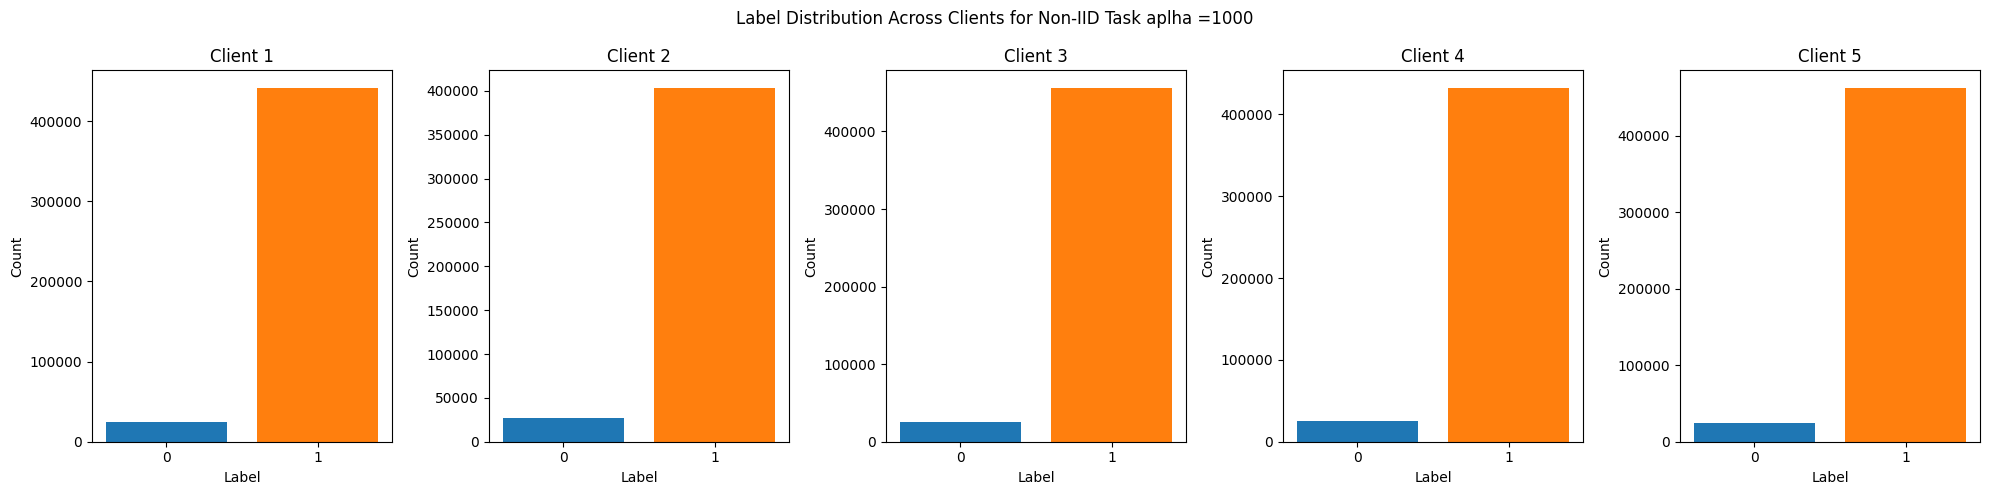

In [17]:
# Plot label distribution
plot_label_distribution(clients_data, task_name ,alpha)


In [26]:
# Create an LSTM model
def create_lstm_model(input_shape, nb_classes):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(128)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(nb_classes, activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model
# Apply SMOTE to the dataset
def apply_smote(X, y):
    y_labels = np.argmax(y, axis=1) if y.ndim > 1 else y
    smote = SMOTE()
    try:
        X_reshaped = X.reshape(X.shape[0], -1)
        X_resampled, y_resampled_labels = smote.fit_resample(X_reshaped, y_labels)
        y_resampled = to_categorical(y_resampled_labels, num_classes=y.shape[1])
        X_resampled_reshaped = X_resampled.reshape(-1, X.shape[1], X.shape[2])
        return X_resampled_reshaped, y_resampled
    except Exception as e:
        print(f"SMOTE could not be applied: {e}")
        return X, y

# Federated averaging to aggregate client weights
def fedavg_aggregate(client_weights_list):
    average_weights = []
    for layer in range(len(client_weights_list[0])):
        layer_weights = np.mean([client_weights[layer] for client_weights in client_weights_list], axis=0)
        average_weights.append(layer_weights)
    return average_weights

# Distribute data IID among clients
def distribute_data_iid(X, y, num_clients):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled, y_shuffled = X[indices], y[indices]
    data_size_per_client = len(X_shuffled) // num_clients
    clients_data = [(X_shuffled[i * data_size_per_client: (i + 1) * data_size_per_client],
                     y_shuffled[i * data_size_per_client: (i + 1) * data_size_per_client]) for i in range(num_clients)]
    if len(X_shuffled) % num_clients != 0:
        clients_data[-1] = (np.concatenate((clients_data[-1][0], X_shuffled[num_clients * data_size_per_client:])),
                            np.concatenate((clients_data[-1][1], y_shuffled[num_clients * data_size_per_client:])))
    return clients_data



# Plot label distribution for each client


# Train and evaluate the local model for a client
def train_and_evaluate_client_model(x_local, y_local, model_config, epochs=1, batch_size=32):
    if x_local.size == 0 or y_local.size == 0:
        print("Skipping training and evaluation due to an empty dataset.")
        return None, None
    local_model = Sequential.from_config(model_config)
    if y_local.ndim == 1 or y_local.shape[1] != model_config['layers'][-1]['config']['units']:
        y_local = to_categorical(y_local, num_classes=model_config['layers'][-1]['config']['units'])
    local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    local_model.fit(x_local, y_local, epochs=epochs, batch_size=batch_size, verbose=0)
    loss, accuracy = local_model.evaluate(x_local, y_local, verbose=1)
    return local_model.get_weights(), accuracy

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from imblearn.over_sampling import SMOTE

# Create improved LSTM model
def create_lstm_model(input_shape, nb_classes):
    model = Sequential([
        Bidirectional(LSTM(256, return_sequences=True), input_shape=input_shape),
        BatchNormalization(),
        Dropout(0.3),
        Bidirectional(LSTM(128)),
        BatchNormalization(),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(nb_classes, activation='softmax')
    ])
    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Apply SMOTE to the dataset
def apply_smote(X, y):
    y_labels = np.argmax(y, axis=1) if y.ndim > 1 else y
    smote = SMOTE()
    try:
        X_reshaped = X.reshape(X.shape[0], -1)
        X_resampled, y_resampled_labels = smote.fit_resample(X_reshaped, y_labels)
        y_resampled = to_categorical(y_resampled_labels, num_classes=y.shape[1] if y.ndim > 1 else len(np.unique(y_labels)))
        X_resampled_reshaped = X_resampled.reshape(-1, X.shape[1], X.shape[2])
        return X_resampled_reshaped, y_resampled
    except Exception as e:
        print(f"SMOTE could not be applied: {e}")
        return X, y

# Federated averaging to aggregate client weights
def fedavg_aggregate(client_weights_list):
    average_weights = []
    for layer in range(len(client_weights_list[0])):
        layer_weights = np.mean([client_weights[layer] for client_weights in client_weights_list], axis=0)
        average_weights.append(layer_weights)
    return average_weights

# Distribute data IID among clients
def distribute_data_iid(X, y, num_clients):
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    X_shuffled, y_shuffled = X[indices], y[indices]
    data_size_per_client = len(X_shuffled) // num_clients
    clients_data = [(X_shuffled[i * data_size_per_client: (i + 1) * data_size_per_client],
                     y_shuffled[i * data_size_per_client: (i + 1) * data_size_per_client]) for i in range(num_clients)]
    if len(X_shuffled) % num_clients != 0:
        clients_data[-1] = (np.concatenate((clients_data[-1][0], X_shuffled[num_clients * data_size_per_client:])),
                            np.concatenate((clients_data[-1][1], y_shuffled[num_clients * data_size_per_client:])))
    return clients_data

# Train and evaluate the local model for a client
def train_and_evaluate_client_model(x_local, y_local, model_config, epochs=1, batch_size=32):
    if x_local.size == 0 or y_local.size == 0:
        print("Skipping training and evaluation due to an empty dataset.")
        return None, None
    local_model = Sequential.from_config(model_config)
    # Check if y_local needs to be one-hot encoded
    expected_classes = model_config['layers'][-1]['config']['units']
    if y_local.ndim == 1 or (y_local.ndim == 2 and y_local.shape[1] != expected_classes):
        y_local = to_categorical(y_local, num_classes=expected_classes)
    local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    local_model.fit(x_local, y_local, epochs=epochs, batch_size=batch_size, verbose=0)
    loss, accuracy = local_model.evaluate(x_local, y_local, verbose=0)
    return local_model.get_weights(), accuracy

# -------- Example usage and federated learning loop --------

# Assuming you have preprocessed data X, y and validation data x_val, y_val
# Also defined: timesteps, features, num_rounds, num_clients, task_name

# Example placeholder variables (replace with your actual preprocessed data)
# X, y, timesteps, features should come from your data loading/preprocessing function
# x_val, y_val should be validation data
# num_rounds = 10
# num_clients = 5
# task_name = "EV Charging Security"

# Distribute data among clients
clients_data = distribute_data_iid(X, y, num_clients)

# Determine number of classes (y is 1D array of labels)
num_classes = len(np.unique(y))

# Create global model config
global_model_config = create_lstm_model((timesteps, features), num_classes).get_config()
global_accuracies = []

for round_num in range(1, num_rounds + 1):
    print(f"\nRound {round_num}")

    client_weights = []
    for x_client, y_client in clients_data:
        weights, accuracy = train_and_evaluate_client_model(x_client, y_client, global_model_config)
        if weights is not None:
            client_weights.append(weights)
            print(f"Local model accuracy: {accuracy:.4f}")
        else:
            print("Client training skipped due to empty data.")

    # Aggregate client weights if any clients trained
    if client_weights:
        new_global_weights = fedavg_aggregate(client_weights)
        global_model = Sequential.from_config(global_model_config)
        global_model.set_weights(new_global_weights)
        global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

        # Ensure y_val is one-hot encoded
        if y_val.ndim == 1:
            y_val = to_categorical(y_val, num_classes=num_classes)

        # Evaluate global model
        loss, acc = global_model.evaluate(x_val, y_val, verbose=1)
        global_accuracies.append(acc)
        print(f"Global model accuracy after round {round_num}: {acc:.4f}")
    else:
        print("No client weights to aggregate.")

# Plotting global model accuracy across rounds
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(global_accuracies) + 1), global_accuracies, marker='o', linestyle='-', color='b')
plt.xlabel('Federated Learning Round')
plt.ylabel('Global Model Accuracy')
plt.title(f'Global Model Accuracy Across Federated Learning Rounds with FedAvg for {task_name} Task')
plt.ylim(0, 1)
plt.grid(True)
plt.show()



Round 1
Local model accuracy: 0.9451
Local model accuracy: 0.9999
Local model accuracy: 0.9999
Local model accuracy: 0.9999
Local model accuracy: 0.9999
18145/18145 ━━━━━━━━━━━━━━━━━━━━ 23s 1ms/step - accuracy: 0.9450 - loss: 0.4814
Global model accuracy after round 1: 0.9452

Round 2
Local model accuracy: 0.9451
Local model accuracy: 0.9999
Local model accuracy: 0.9999
Local model accuracy: 0.9999
Local model accuracy: 0.9999
18145/18145 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - accuracy: 0.9450 - loss: 0.4859
Global model accuracy after round 2: 0.9452

Round 3
Local model accuracy: 0.9451
Local model accuracy: 0.9999
Local model accuracy: 0.9999
Local model accuracy: 0.9999
Local model accuracy: 0.9999
18145/18145 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - accuracy: 0.9450 - loss: 0.4879
Global model accuracy after round 3: 0.9452

Round 4
Local model accuracy: 0.9451
Local model accuracy: 0.9999
Local model accuracy: 0.9999
Local model accuracy: 0.9999
Local model accuracy: 0.9999
18145/18145 